### 1. Import Libraries

We import the core Python libraries needed for this project:
- **pandas** for data loading and cleaning  
- **numpy** for numerical regression  
- **matplotlib** for visualization  
- set the global plotting style for consistency


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


### 2. Load and Prepare Fama–French 5-Factor Data

The FF5 dataset is provided in **daily format**, so we first:
1. Load the raw daily CSV
2. Remove footer text rows
3. Convert the date to a proper `datetime`
4. Forward-fill missing values
5. Resample from **daily → monthly (end of month)**
6. Convert the monthly dates to **month-start** to align with our market data

This ensures both datasets use the *same monthly timestamps*.

In [15]:
# Load FF5
ff = pd.read_csv("data/raw/ff5_data.csv")
ff = ff[ff["Date"].astype(str).str.isdigit()]
ff["date"] = pd.to_datetime(ff["Date"].astype(str), format="%Y%m%d")
ff = ff.drop(columns=["Date"]).sort_values("date").reset_index(drop=True)

# Forward-fill missing factor values
factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
ff[factor_cols] = ff[factor_cols].ffill()

# monthly end-of-month
ff_monthly = ff.resample("M", on="date").last().reset_index()

ff_monthly["date"] = (
    ff_monthly["date"].dt.to_period("M").dt.to_timestamp("M")
    - pd.offsets.MonthEnd(1)
    + pd.offsets.MonthBegin(1)
)

ff_monthly.head()


/var/folders/5k/rhxzp5ms4dx5vkqkktfv1nk00000gn/T/ipykernel_92575/441391847.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff_monthly = ff.resample("M", on="date").last().reset_index()


,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.13,0.12,-0.01,-0.15,0.34,0.01
1,1963-08-01,0.44,0.11,-0.06,0.11,-0.27,0.01
2,1963-09-01,-0.60,0.19,0.10,0.20,-0.04,0.01
3,1963-10-01,0.21,-0.04,0.09,0.13,-0.32,0.01
4,1963-11-01,1.34,0.33,0.30,-0.23,-0.19,0.02


### 3. Load Market Return Data (Monthly)

We load the pre-cleaned **monthly return matrix** of S&P 500 constituents.
The dataset is already in wide format (`ticker columns`), and dates are already the **first day of each month**, so minimal cleaning is needed.

In [16]:
market = pd.read_csv("data/raw/market_data.csv", parse_dates=["Date"])
market = market.rename(columns={"Date": "date"})
market = market.sort_values("date").reset_index(drop=True)

market.head()


,date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
0,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-01,0.085481,0.166710,NaN,NaN,0.027218,0.129322,-0.019194,0.085237,0.023127,...,0.072596,0.091672,-0.025838,0.226938,NaN,NaN,0.054695,0.089410,-0.020813,NaN
2,2005-03-01,-0.075000,-0.071110,NaN,NaN,0.013699,-0.034716,-0.054795,0.087773,-0.014175,...,0.030018,-0.053514,-0.030474,-0.053990,NaN,NaN,0.062115,-0.094179,-0.047724,NaN
3,2005-04-01,-0.065315,-0.134629,NaN,NaN,0.054483,-0.001249,-0.101449,-0.114461,-0.056170,...,0.001606,-0.218483,0.012446,-0.043121,NaN,NaN,-0.093611,0.046395,0.005685,NaN
4,2005-05-01,0.157108,0.102607,NaN,NaN,-0.013048,0.116529,0.072811,0.113839,0.087071,...,-0.065005,-0.115035,0.072759,-0.014553,NaN,NaN,0.094341,-0.059445,-0.108878,NaN


### 4. Merge Market Returns with Factor Data

We merge the monthly market returns with the aligned monthly FF5 factors.
The merge occurs cleanly after aligning FF5 month-end dates to month-start.

We also fix column naming issues (e.g., `RF_y`) that arise from merging datasets with overlapping column names.

In [17]:
df = market.merge(ff_monthly, on="date", how="inner")

if "RF_y" in df.columns:
    df = df.rename(columns={"RF_y": "RF"})
if "RF_x" in df.columns:
    df = df.drop(columns=["RF_x"])

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
tickers = [c for c in df.columns if c not in ["date"] + factor_cols]

df.head()


,date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,YUM,ZBH,ZBRA,ZTS,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.97,0.85,0.14,-0.21,-0.11,0.01
1,2005-02-01,0.085481,0.166710,NaN,NaN,0.027218,0.129322,-0.019194,0.085237,0.023127,...,0.054695,0.089410,-0.020813,NaN,-0.61,0.23,0.05,0.41,0.16,0.01
2,2005-03-01,-0.075000,-0.071110,NaN,NaN,0.013699,-0.034716,-0.054795,0.087773,-0.014175,...,0.062115,-0.094179,-0.047724,NaN,-0.01,0.07,0.64,0.03,0.26,0.01
3,2005-04-01,-0.065315,-0.134629,NaN,NaN,0.054483,-0.001249,-0.101449,-0.114461,-0.056170,...,-0.093611,0.046395,0.005685,NaN,1.04,-0.41,-0.05,-0.16,-0.14,0.01
4,2005-05-01,0.157108,0.102607,NaN,NaN,-0.013048,0.116529,0.072811,0.113839,0.087071,...,0.094341,-0.059445,-0.108878,NaN,-0.49,0.47,0.32,-0.12,0.14,0.01


### 5. Compute Excess Returns for Each Stock

To prepare the regression inputs, we convert raw stock returns into **excess returns**:

\[
R_{i,t}^{excess} = R_{i,t} - RF_t
\]

This is standard in multi-factor regression based on FF5.


In [18]:
for t in tickers:
    df[t] = df[t] - df["RF"] / 100


### 6. Ordinary Least Squares (OLS) via NumPy

We implement a pure NumPy closed-form OLS function:

\[
\beta = (X^T X)^{-1} X^T y
\]



In [19]:
def ols_numpy(X, y):
    """Perform closed-form OLS regression."""
    return np.linalg.inv(X.T @ X) @ (X.T @ y)


### 7. Rolling-Window Factor Regression

For each stock, we regress 36 months of excess returns on the FF5 factors:

\[
R^{excess}_{i,t} = \alpha_i + \beta_{i}^T F_t + \epsilon_t
\]

We slide the window forward one month at a time and store each month’s estimated betas.
This produces a time series of factor loadings for every stock.


In [20]:
def rolling_factor_loadings(df, ticker, window=36):
    betas = []
    dates = []

    y = df[ticker].values
    X = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].values
    X = np.column_stack([np.ones(len(X)), X])

    for i in range(window, len(df)):
        beta = ols_numpy(X[i-window:i], y[i-window:i])
        betas.append(beta)
        dates.append(df["date"].iloc[i])

    return pd.DataFrame(
        betas,
        index=dates,
        columns=["alpha", "MKT", "SMB", "HML", "RMW", "CMA"]
    )


### 8. Run Rolling-Window Regressions Across All S&P 500 Tickers

We apply the rolling regression to every ticker in the dataset.
Some tickers may be skipped due to insufficient return history (e.g., IPOs).

In [21]:
beta_dict = {}

for t in tickers:
    print("Running:", t)
    try:
        beta_dict[t] = rolling_factor_loadings(df, t)
    except Exception as e:
        print(f"Skipping {t}: {e}")


Running: A
Running: AAPL
Running: ABBV
Running: ABNB
Running: ABT
Running: ACGL
Running: ACN
Running: ADBE
Running: ADI
Running: ADM
Running: ADP
Running: ADSK
Running: AEE
Running: AEP
Running: AES
Running: AFL
Running: AIG
Running: AIZ
Running: AJG
Running: AKAM
Running: ALB
Running: ALGN
Running: ALL
Running: ALLE
Running: AMAT
Running: AMCR
Running: AMD
Running: AME
Running: AMGN
Running: AMP
Running: AMT
Running: AMZN
Running: ANET
Running: AON
Running: AOS
Running: APA
Running: APD
Running: APH
Running: APO
Running: APP
Running: APTV
Running: ARE
Running: ATO
Running: AVB
Running: AVGO
Running: AVY
Running: AWK
Running: AXON
Running: AXP
Running: AZO
Running: BA
Running: BAC
Running: BALL
Running: BAX
Running: BBY
Running: BDX
Running: BEN
Running: BF.B
Running: BG
Running: BIIB
Running: BK
Running: BKNG
Running: BKR
Running: BLDR
Running: BLK
Running: BMY
Running: BR
Running: BRK.B
Running: BRO
Running: BSX
Running: BX
Running: BXP
Running: C
Running: CAG
Running: CAH
Running: C

### 9. Predict Future Returns Using Rolling Betas

We forecast next-month returns by multiplying the current factor exposures (betas) with next-month factor realizations:

\[
\hat{R}_{i,t+1} = \beta_{i,t}^T F_{t+1}
\]

This gives us a cross-sectional expected return for each stock.


In [22]:
factors_next = df[["date","Mkt-RF","SMB","HML","RMW","CMA"]].shift(-1)

predictions = {}

for t in tickers:
    betas = beta_dict.get(t)
    if betas is None:
        continue

    idx = betas.index.intersection(factors_next["date"])
    beta_mat = betas.loc[idx, ["MKT","SMB","HML","RMW","CMA"]].values
    factor_mat = factors_next.set_index("date").loc[idx, ["Mkt-RF","SMB","HML","RMW","CMA"]].values

    predictions[t] = pd.Series((beta_mat * factor_mat).sum(axis=1), index=idx)

pred_df = pd.DataFrame(predictions)
pred_df.head()


,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-01,0.093904,0.144682,NaN,NaN,-0.044745,0.068733,0.113630,0.127770,0.109697,0.091982,...,0.052303,0.116658,0.014489,0.102014,NaN,NaN,0.030999,0.010298,-0.018396,NaN
2008-03-01,0.018769,-0.011212,NaN,NaN,0.035509,-0.040292,-0.018941,0.011015,0.004600,0.015639,...,0.020366,-0.038363,0.012345,-0.006879,NaN,NaN,-0.024133,0.051989,-0.024473,NaN
2008-04-01,0.028319,0.076049,NaN,NaN,0.012369,-0.010941,0.026558,0.056674,0.045920,-0.018513,...,0.044963,0.003873,0.008973,0.029242,NaN,NaN,0.010603,0.035732,0.030091,NaN
2008-05-01,0.051162,0.105811,NaN,NaN,0.022258,-0.038870,0.021066,0.039826,0.057878,-0.025171,...,0.038356,0.046618,0.013827,0.040368,NaN,NaN,0.020218,0.063740,0.010483,NaN


### 10. Long-Only Portfolio Construction (Top 50 Stocks)

Each month:
- Sort predicted returns
- Select the **top 50 stocks**
- Assign equal weights (1/50 each)

This produces a simple, transparent long-only factor strategy.

In [23]:
def build_long_only_portfolio(pred_df, k=50):
    weights = pd.DataFrame(0, index=pred_df.index, columns=pred_df.columns)
    for dt, row in pred_df.iterrows():
        top_k = row.nlargest(k).index
        weights.loc[dt, top_k] = 1/k
    return weights

weights = build_long_only_portfolio(pred_df)
weights.head()


/var/folders/5k/rhxzp5ms4dx5vkqkktfv1nk00000gn/T/ipykernel_92575/3335424768.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[dt, top_k] = 1/k
/var/folders/5k/rhxzp5ms4dx5vkqkktfv1nk00000gn/T/ipykernel_92575/3335424768.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[dt, top_k] = 1/k
/var/folders/5k/rhxzp5ms4dx5vkqkktfv1nk00000gn/T/ipykernel_92575/3335424768.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[dt, top_k] =

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2008-01-01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2008-02-01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,...,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2008-03-01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0
2008-04-01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.00,...,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2008-05-01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


### 11. Realized Next-Month Portfolio Returns

We compute realized returns using the next month's actual stock returns:

\[
R^{portfolio}_t = \sum_i w_{i,t} R_{i,t+1}
\]

This allows us to evaluate how well the predictions performed out-of-sample.


In [24]:
future_returns = df.set_index("date")[tickers].shift(-1)
portfolio_returns = (weights * future_returns).sum(axis=1)
portfolio_returns.head()

2005-01-01    0.0
2005-02-01    0.0
2005-03-01    0.0
2005-04-01    0.0
2005-05-01    0.0
dtype: float64

### 12. Load S&P 500 (SPY) Benchmark Returns

We load monthly S&P 500 returns to benchmark our strategy.
The benchmark is aligned to the same monthly timestamps as the portfolio.


In [25]:
spy = pd.read_csv("data/raw/gspc_monthly_returns.csv", parse_dates=["Date"])
spy = spy.rename(columns={"Date": "date", "^GSPC": "return"})
spy = spy.set_index("date")["return"]
spy_ret = spy.reindex(portfolio_returns.index)
spy_ret.head()

2005-01-01         NaN
2005-02-01    0.018903
2005-03-01   -0.019118
2005-04-01   -0.020109
2005-05-01    0.029952
Name: return, dtype: float64

### 13. Performance Evaluation: Sharpe Ratio & Cumulative Returns

We compute:
- Annualized Sharpe Ratio  
- Cumulative returns of both the strategy and SPY  
- A comparison plot

The Sharpe ratio measures **risk-adjusted return**:

\[
Sharpe = \frac{E[R]}{\sigma(R)} \times \sqrt{12}
\]

A higher Sharpe indicates better risk-adjusted performance.

Strategy Sharpe: 0.8186240217624793
SPY Sharpe: 0.6298299212171354


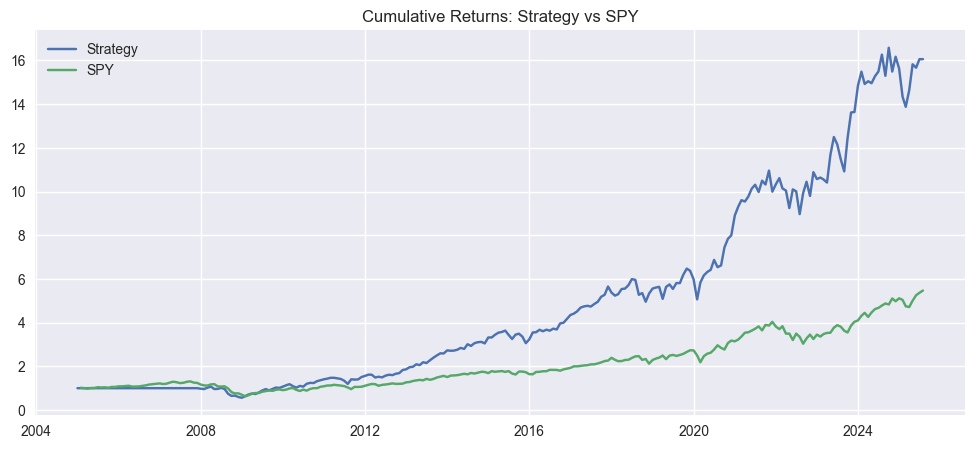

In [26]:
def sharpe_ratio(r):
    return (r.mean() / r.std()) * np.sqrt(12)

cum_port = (1 + portfolio_returns).cumprod()
cum_spy = (1 + spy_ret).cumprod()

print("Strategy Sharpe:", sharpe_ratio(portfolio_returns))
print("SPY Sharpe:", sharpe_ratio(spy_ret))

plt.figure(figsize=(12,5))
plt.plot(cum_port, label="Strategy")
plt.plot(cum_spy, label="SPY")
plt.legend()
plt.title("Cumulative Returns: Strategy vs SPY")
plt.show()
